<a href="https://colab.research.google.com/github/TakuroTerui/PyOptBook/blob/main/%E6%95%B0%E7%90%86%E6%9C%80%E9%81%A9%E5%8C%96_ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/ohmsha/PyOptBook

Cloning into 'PyOptBook'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 206 (delta 82), reused 71 (delta 46), pack-reused 76
Receiving objects: 100% (206/206), 2.31 MiB | 6.31 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
cd PyOptBook

/content/PyOptBook


- 数理モデルによる決定事項
    - 各会員に対してどのパターンのダイレクトメールを送付するかを決定
- 送付するダイレクトメールの数
    - 各会員に対して送付するダイレクトメールはいずれか1パターンn
- キャンペーンの目的
    - クーポン付与による来客増加数を最大化する
- キャンペーン予算
    - 会員の予算消費期待値の合計は100万円以下
- 次回以降のクーポンキャンペーンで利用する来店率の収集
    - 各パターンのダイレクトメールをそれぞれのセグメントに属する会員の10%以上に送付

In [3]:
import pandas as pd
cust_df = pd.read_csv('4.coupon/customers.csv')
cust_df.shape

(5000, 3)

In [4]:
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [5]:
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

<Axes: >

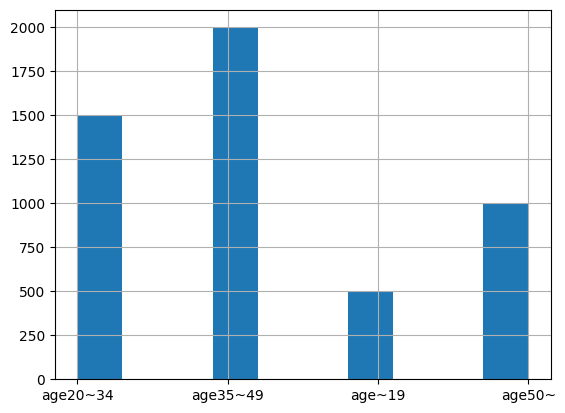

In [6]:
cust_df['age_cat'].hist()

<Axes: >

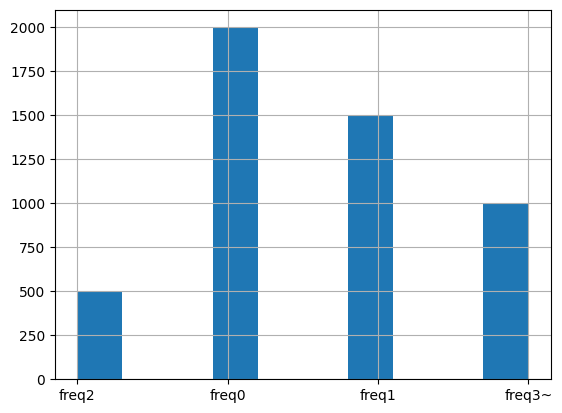

In [7]:
cust_df['freq_cat'].hist()

In [8]:
cust_pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<Axes: xlabel='freq_cat', ylabel='age_cat'>

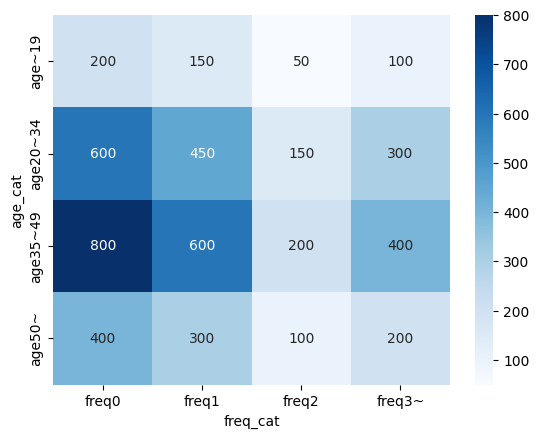

In [9]:
import seaborn as sns
sns.heatmap(cust_pivot_df, annot=True, fmt='d', cmap='Blues')

In [10]:
prob_df = pd.read_csv('4.coupon/visit_probability.csv')
prob_df.shape

(16, 6)

In [11]:
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


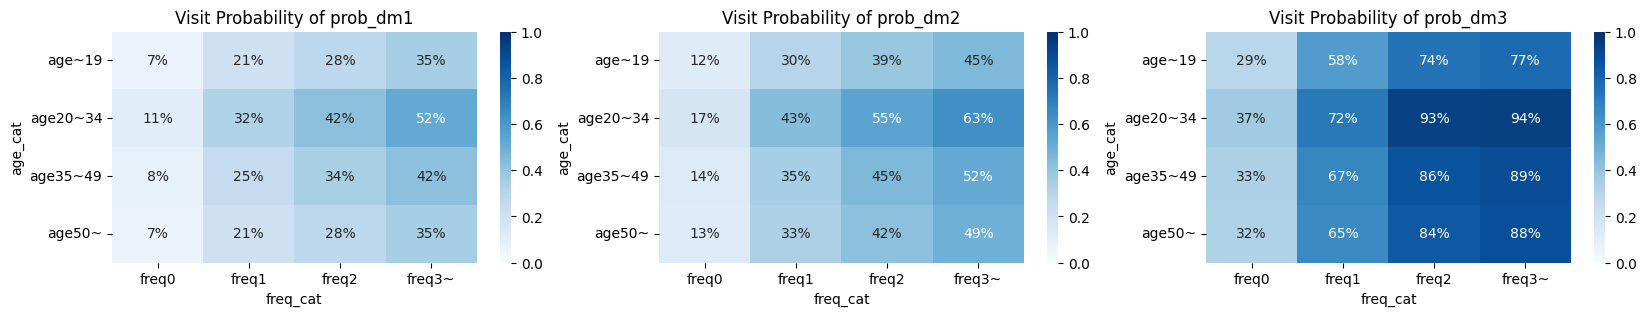

In [12]:
import matplotlib.pyplot as plt

ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i,  ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

## モデリング1：会員個別送付モデル

In [13]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 56.4 MB/s eta 0:00:00


In [14]:
import pulp

problem = pulp.LpProblem(name='DiscountCouponProblem1', sense=pulp.LpMaximize)

In [15]:
# 会員IDのリスト
I = cust_df['customer_id'].to_list()
len(I)

5000

In [16]:
# ダイレクトメールのパターンリスト
M = [1, 2, 3]

In [17]:
# (1) 各会員に対してどのパターンのダイレクトメールを送付するかを決定
xim = {}
for i in I:
    for m in M:
        xim[i, m] = pulp.LpVariable(name=f'xim({i}, {m})', cat='Binary')
# 決定係数の数
len(xim)

15000

In [18]:
# (2) 各会員に対して送付するダイレクトメールはいずれか1パターン
for i in I:
    problem += pulp.lpSum(xim[i, m] for m in M) == 1

In [19]:
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [20]:
cust_prob_ver_df = cust_prob_df.rename(columns={'prob_dm1':1, 'prob_dm2':2, 'prob_dm3':3}).melt(
    id_vars=['customer_id'], value_vars=[1, 2, 3], var_name='dm', value_name='prob')
cust_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [21]:
Pim = cust_prob_ver_df.set_index(['customer_id', 'dm'])['prob'].to_dict()

In [22]:
Pim[1, 1]

0.42

In [23]:
# (3) クーポン付与による来客増加数を最大化
problem += pulp.lpSum((Pim[i, m] - Pim[i, 1]) * xim[i, m] for i in I for m in [2, 3])

In [24]:
Cm = {1:0, 2:1000, 3:2000}

In [25]:
# (4) 顧客の消費する費用の期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Pim[i, m] * xim[i, m] for i in I for m in [2, 3]) <= 1000000

In [26]:
# セグメントのリスト
S = prob_df['segment_id'].to_list()
len(S)

16

In [27]:
# 各セグメントとそのセグメントに属する顧客数を対応させる辞書の作成
Ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(Ns)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [28]:
# 会員をキーとして属するセグメントを返す辞書
Si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()
len(Si)

5000

In [29]:
# (5) 各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
for s in S:
    for m in M:
        problem += pulp.lpSum(xim[i, m] for i in I if Si[i] == s) >= 0.1 * Ns[s]

In [30]:
# 時間を計測
import time
# モデリング1は、一部の環境ではgapRel（計算の終了判定とする上界と下界のギャップのしきい値）を指定しないと停止しない
solver = pulp.PULP_CBC_CMD(gapRel=10e-4)

time_start = time.time()
status = problem.solve(solver)
time_stop = time.time()

print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間：{(time_stop - time_start):.3}(秒)')

ステータス:Optimal
目的関数値:326.1
計算時間：6.49(秒)


In [31]:
send_dm_df = pd.DataFrame([[xim[i,m].value() for m in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])
send_dm_df.head()

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [32]:
cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,1.0,0.0
4,5,age35~49,freq0,0.0,1.0,0.0


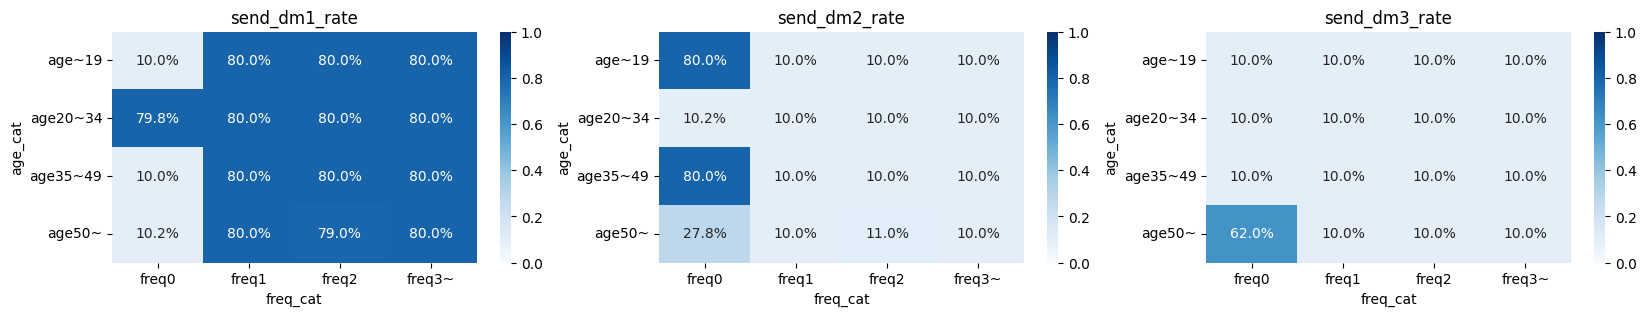

In [33]:
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}_rate')
plt.show()

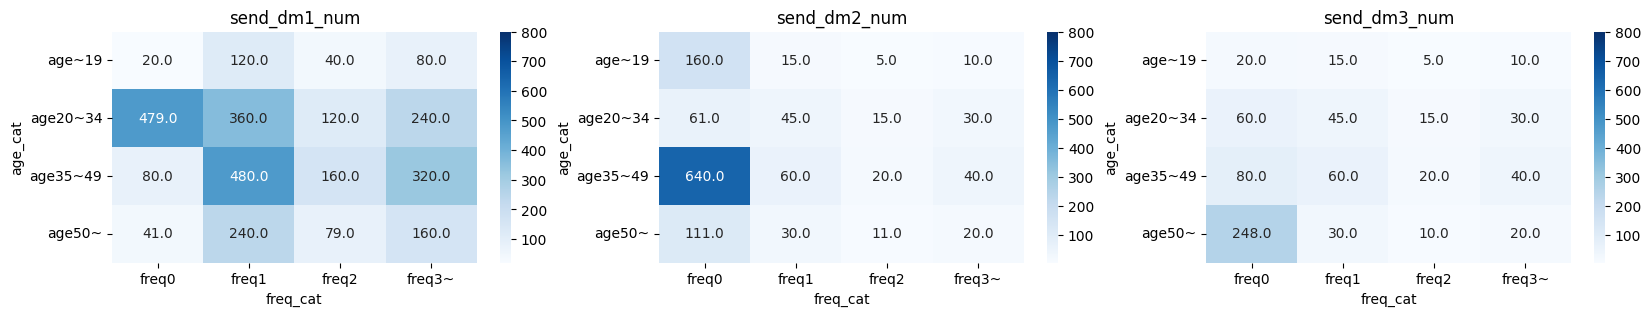

In [34]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat',aggfunc='sum')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}_num')
plt.show()

## モデリング2：セグメント送付モデル

In [35]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)

In [38]:
# (1) 各会員に対してどのパターンのダイレクトメールを送付するかを決定
xsm = {}
# [0, 1]の変数を定義
for s in S:
    for m in M:
        xsm[s, m] = pulp.LpVariable(name=f'xsm({s}, {m})', lowBound=0, upBound=1, cat='Continuous')
len(xsm)

48

In [39]:
# (2) 各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s, m] for m in M) == 1

In [41]:
prob_ver_df = prob_df.rename(columns={'prob_dm1':1, 'prob_dm2':2, 'prob_dm3':3}).melt(id_vars=['segment_id'], value_vars=[1, 2, 3], var_name='dm', value_name='prob')
Psm = prob_ver_df.set_index(['segment_id', 'dm'])['prob'].to_dict()
print(Psm)

{(1, 1): 0.07, (2, 1): 0.21, (3, 1): 0.28, (4, 1): 0.35, (5, 1): 0.11, (6, 1): 0.32, (7, 1): 0.42, (8, 1): 0.52, (9, 1): 0.08, (10, 1): 0.25, (11, 1): 0.34, (12, 1): 0.42, (13, 1): 0.07, (14, 1): 0.21, (15, 1): 0.28, (16, 1): 0.35, (1, 2): 0.12, (2, 2): 0.3, (3, 2): 0.39, (4, 2): 0.45, (5, 2): 0.17, (6, 2): 0.43, (7, 2): 0.55, (8, 2): 0.63, (9, 2): 0.14, (10, 2): 0.35, (11, 2): 0.45, (12, 2): 0.52, (13, 2): 0.13, (14, 2): 0.33, (15, 2): 0.42, (16, 2): 0.49, (1, 3): 0.29, (2, 3): 0.58, (3, 3): 0.74, (4, 3): 0.77, (5, 3): 0.37, (6, 3): 0.72, (7, 3): 0.93, (8, 3): 0.94, (9, 3): 0.33, (10, 3): 0.67, (11, 3): 0.86, (12, 3): 0.89, (13, 3): 0.32, (14, 3): 0.65, (15, 3): 0.84, (16, 3): 0.88}


In [43]:
# (3) クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3])

In [44]:
# (4) 会員の予算消費期待値の会計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3]) <= 1000000

In [45]:
# (5) 各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10％以上送付
for s in S:
    for m in M:
        problem += xsm[s, m] >= 0.1

In [48]:
time_start = time.time()
status = problem.solve()
time_stop = time.time()

print(f'ステータス:{pulp.LpStatus[status]}')
print(f'目的関数値:{pulp.value(problem.objective):.4}')
print(f'計算時間：{(time_stop - time_start):.3}(秒)')

ステータス:Optimal
目的関数値:326.1
計算時間：0.0755(秒)


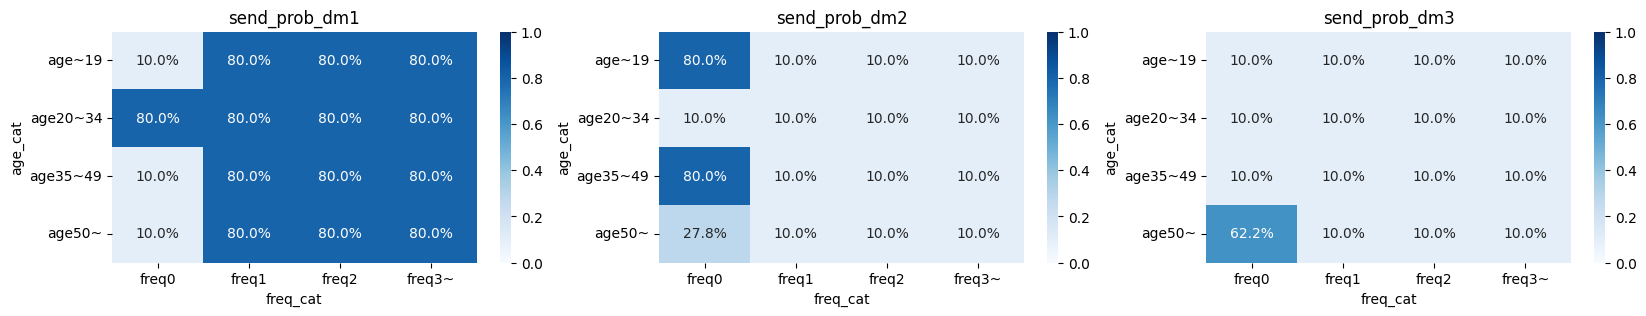

In [49]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M] for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
# 各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [50]:
seg_send_df['num_cust'] = seg_send_df['segment_id'].apply(lambda x: Ns[x])
seg_send_df['send_num_dm1'] = seg_send_df['send_prob_dm1']*seg_send_df['num_cust']
seg_send_df['send_num_dm2'] = seg_send_df['send_prob_dm2']*seg_send_df['num_cust']
seg_send_df['send_num_dm3'] = seg_send_df['send_prob_dm3']*seg_send_df['num_cust']
seg_send_df[['segment_id','send_num_dm1','send_num_dm2','send_num_dm3']].head()

,segment_id,send_num_dm1,send_num_dm2,send_num_dm3
0,1,20.0,160.0,20.0
1,2,120.0,15.0,15.0
2,3,40.0,5.0,5.0
3,4,80.0,10.0,10.0
4,5,480.0,60.0,60.0


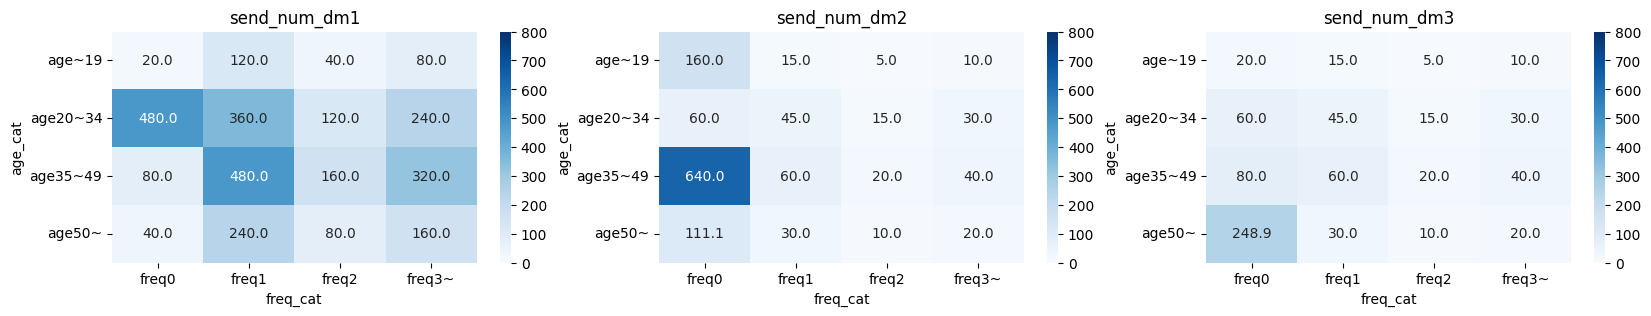

In [51]:
# 各セグメントに対するそれぞれのダイレクトメールの送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_num_dm1','send_num_dm2','send_num_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat', index='age_cat')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

### モデリング3：送付率下限値最大化モデル

In [52]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)

In [53]:
# (1) 各セグメントへのそれぞれのパターンのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定

# 会員に対してどのダイレクトメールを送付する
xsm = {}
# [0, 1]の変数を宣言
for s in S:
    for m in M:
        xsm[s, m] = pulp.LpVariable(name=f'xsm({s}, {m})', lowBound=0, upBound=1, cat='Continuous')

# 各セグメントへのそれぞれパターンのダイレクトメールの送付率の下限値
y = pulp.LpVariable(name='y', lowBound=0, upBound=1, cat='Continuous')

In [54]:
# (3) 各セグメントへの各パターンのダイレクトメールの送付率の下限値を最大化
problem += y

In [55]:
# (5) 各パターンのダイレクトメールを設置した送付率の下限値以上送付
for s in S:
    for m in M:
        problem += xsm[s, m] >= y

In [56]:
# (2) 各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s, m] for m in M) == 1

# (4) 会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3]) <= 1000000

In [57]:
status = problem.solve()
max_lowerbound = pulp.value(problem.objective)
print(f'ステータス:{pulp.LpStatus[status]}, 目的関数値：{max_lowerbound:.3}')

ステータス:Optimal, 目的関数値：0.131


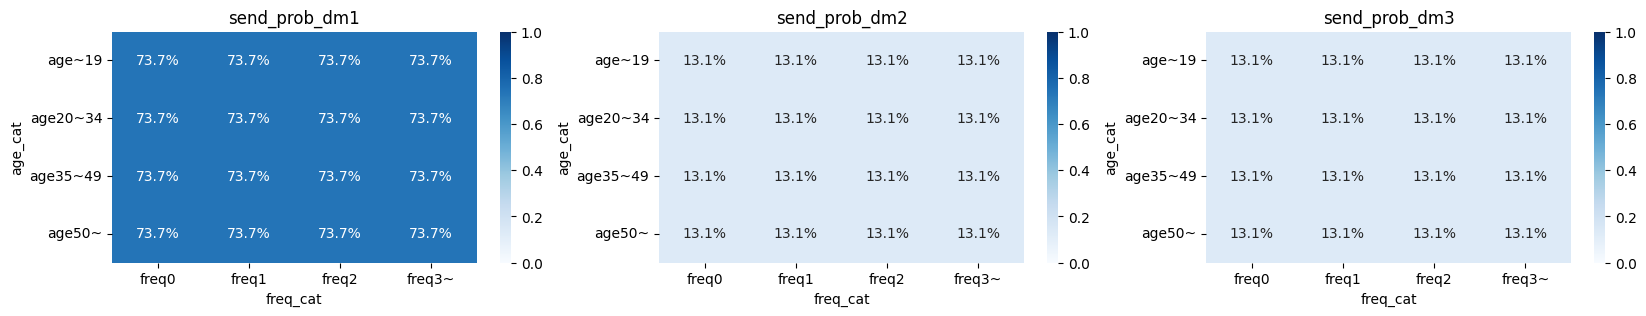

In [58]:
send_dm_df = pd.DataFrame([[xsm[s,m].value() for m in M]for s in S], columns=['send_prob_dm1', 'send_prob_dm2','send_prob_dm3'])
seg_send_df = pd.concat([prob_df[['segment_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['send_prob_dm1', 'send_prob_dm2', 'send_prob_dm3']):
    seg_send_pivot_df = pd.pivot_table(data=seg_send_df,values=ptn, columns='freq_cat',index='age_cat', aggfunc='mean')
    seg_send_pivot_df = seg_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(seg_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'{ptn}')
plt.show()

In [60]:
# 数理モデルのインスタンス作成
problem = pulp.LpProblem(name='DiscountCouponProblem3', sense=pulp.LpMaximize)

# (1) 各セグメントへの各パターンのダイレクトメールの送付率の下限値と各会員に対してどのダイレクトメールを送付するかを決定

# 会員に対してどのダイレクトメールを送付するか
x = {}
# [0, 1]の変数を宣言
for s in S:
    for m in M:
        xsm[s, m] = pulp.LpVariable(name=f'xsm({s}, {m})', lowBound=0, upBound=1, cat='Continuous')

# (2) 各会員に対して送付するダイレクトメールはいずれか1パターン
for s in S:
    problem += pulp.lpSum(xsm[s, m] for m in M) == 1

# (3) クーポン付与による来客増加数を最大化
problem += pulp.lpSum(Ns[s]* (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3])

# (4) 会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3]) <= 1000000

# (5) 各パターンのダイレクトメールを設定した送付率の下限値以上送付
for s in S:
    for m in M:
        problem += xsm[s, m] >= max_lowerbound

status = problem.solve()
print(f'ステータス：{pulp.LpStatus[status]}, 目的関数値:{pulp.value(problem.objective):.4}')

ステータス：Optimal, 目的関数値:300.6


### 投資対効果の評価

In [61]:
cost_list = []
cpa_list = []
inc_action_list = []

In [62]:
print('ステータス, キャンペーン費用, 来客増加数, CPA')
for cost in range(761850, 3000000, 100000):
    # 数理モデルのインスタンス作成
    problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)
    # （1）各会員に対してどのダイレクトメールを送付するかを決定
    xsm = {}
    # [0,1]の変数を宣言
    for s in S:
        for m in M:
            xsm[s,m] = pulp.LpVariable(name=f'xsm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
    # （2）各会員に対して送付するダイレクトメールはいずれか1パターン
    for s in S:
        problem += pulp.lpSum(xsm[s,m] for m in M) == 1
    # （3）クーポン付与による来客増加数を最大化
    problem += pulp.lpSum(Ns[s] * (Psm[s,m] - Psm[s,1]) * xsm[s,m] for s in S for m in [2,3])
    # （4）会員の予算消費期待値の合計はcost円以下
    problem += pulp.lpSum(Cm[m] * Ns[s] * Psm[s,m] * xsm[s,m] for s in S for m in [2,3]) <= cost
    # （5）各パターンのダイレクトメールを設定した送付率の下限値以上に送付
    for s in S:
        for m in M:
            problem += xsm[s,m] >= 0.1
    status = problem.solve()
    cpa = cost/pulp.value(problem.objective)
    inc_action = pulp.value(problem.objective)
    cost_list.append(cost)
    cpa_list.append(cpa)
    inc_action_list.append(inc_action)
    print(f'{pulp.LpStatus[status]}, {cost}, {inc_action :.4}, {cpa :.5}')

ステータス, キャンペーン費用, 来客増加数, CPA
Optimal, 761850, 229.0, 3326.9
Optimal, 861850, 273.1, 3156.3
Optimal, 961850, 311.9, 3084.0
Optimal, 1061850, 349.1, 3042.0
Optimal, 1161850, 385.8, 3011.8
Optimal, 1261850, 422.3, 2988.0
Optimal, 1361850, 458.8, 2968.0
Optimal, 1461850, 495.2, 2951.8
Optimal, 1561850, 530.5, 2944.2
Optimal, 1661850, 565.6, 2938.4
Optimal, 1761850, 600.7, 2933.2
Optimal, 1861850, 634.2, 2935.9
Optimal, 1961850, 667.3, 2940.2
Optimal, 2061850, 700.2, 2944.5
Optimal, 2161850, 732.5, 2951.4
Optimal, 2261850, 764.1, 2960.1
Optimal, 2361850, 795.5, 2969.2
Optimal, 2461850, 826.8, 2977.5
Optimal, 2561850, 858.1, 2985.3
Optimal, 2661850, 889.5, 2992.6
Optimal, 2761850, 920.8, 2999.3
Optimal, 2861850, 951.7, 3007.1
Optimal, 2961850, 981.9, 3016.4


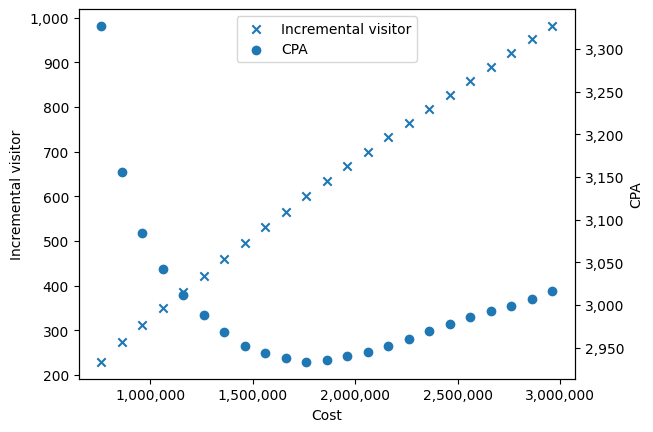

In [63]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.scatter(cost_list, inc_action_list, marker='x', label='Incremental visitor')
ax2.scatter(cost_list, cpa_list, label='CPA')
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x :,.0f}'))
ax1.set_xlabel('Cost')
ax1.set_ylabel('Incremental visitor')
ax2.set_ylabel('CPA')
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc='upper center')
plt.show()